In [1]:
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wprowadzenie
Celem dzisiejszych zajęć jest poruszenie następujących tematów:

1. Wprowadzenie i zapoznanie z konceptem AutoEnkodera
2. Wprowadzenie do modeli generatywnych na podstawie VAE
3. Przykład zastosowania autoenkoderów: wykrywanie anomalii

Przed rozpoczęciem pracy z notebookami, warto przeczytać:
[1] https://www.deeplearningbook.org/contents/autoencoders.html (dostęp na 25.10.2023)

Autorzy:
Piotr Borycki
Piotr Kubacki

# Nienadzorowana reprezentacja danych
Nienadzorowana analiza danych służy do umożliwienia ich zrozumienia, modyfikacji i efektywnego użycia. Aby to zadanie sobie ułatwić, chcemy stworzyć odpowiednią reprezentację. Reprezentację możemy utożsamiać z odwzorowaniem $$ E : X \rightarrow Z $$ gdzie $X$ to zbiór danych, a $Z$ to tzn. przestrzeń kodów ($Z$ jest wymiaru mniejszego od $X$) [2]
Celem tego notebooka jest zapoznanie z koncepcją autoenkodera. Autoenkoder jest nieliniowym uogólnieniem innej metody nienadzorowanej - PCA [2]

# PCA
PCA (principal component analysis / Analiza głównych składowych) to metoda, która dokonuje redukcję wymiarowości poprzez taki obrót układu współrzędnych, aby obrazem odwzorowania była przestrzeń, w której najwięcej zmienności wyjaśniają początkowe czynniki. Załóżmy, że dane w przestrzeni o wymiarze $d$, chcemy zredukować do przestrzeni o wymiarze $k < d$.
 W skrócie, nasz efekt uzyskujemy poprzez:
 1. ustalenie $\lambda_1 , \cdots , \lambda_k$ największych na moduł wartości własnych macierzy kowariancji zbioru danych $X$
 2. skojarzenie z nimi $v_1 , \cdots , v_k$ wektorów własnych, które opisują kierunki największej wariancji danych (nasz pożądany nośnik informacji to ich zmienność) 
3. redukcję przestrzeni danych poprzez odpowiedni obrót układu współrzędnych do $k$ **najbardziej informatywnych kierunków** - te właśnie wskazują wybrane wektory własne

# Przykład 1. 
Zbadajmy przykładową, bardzo prostą próbkę danych (UCI ML Wine Data Set dataset). 

In [2]:
import pandas as pd
winedata = load_wine()
X, y = winedata['data'], winedata['target']

df = pd.DataFrame(X[:,1:4])
df.columns = winedata["feature_names"][1:4]
df

malic_acid   ash  alcalinity_of_ash
0          1.71  2.43               15.6
1          1.78  2.14               11.2
2          2.36  2.67               18.6
3          1.95  2.50               16.8
4          2.59  2.87               21.0
..          ...   ...                ...
173        5.65  2.45               20.5
174        3.91  2.48               23.0
175        4.28  2.26               20.0
176        2.59  2.37               20.0
177        4.10  2.74               24.5

[178 rows x 3 columns]

In [3]:
X.shape     # nasze dane sa w R^13

(178, 13)

Zwizualizujmy trzy przykładowe wymiary naszej próbki danych. **Co można powiedzieć o danych na wykresie?**

In [4]:
import plotly.express as px
fig = px.scatter_3d(df, x=winedata["feature_names"][1], y=winedata["feature_names"][2], z=winedata["feature_names"][3], color=y)
fig.show()
# zrodlo: 

Zredukujmy teraz dane z próbki na dwa wymiary za pomocą PCA.  

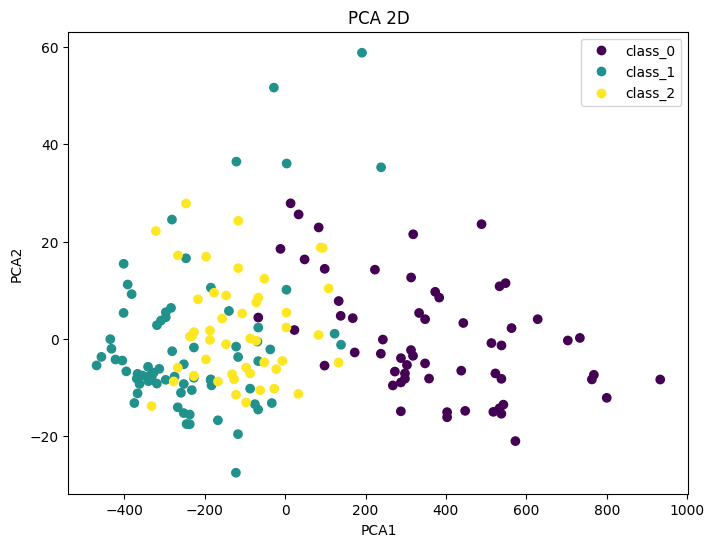

In [5]:
pca = PCA()
plt.figure(figsize=(8,6))
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA 2D")
plt.show()

# ZADANIE 1
Klasy z powyższej reprezentacji nachodzą na siebie. Aby poprawić sytuację zastosujemy StandardScaler z biblioteki sklearn. 

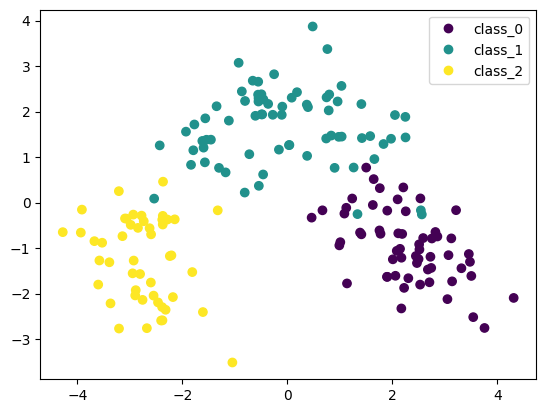

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

Wyjaśnij, z czego wynika różnica w plotach. Na czym polega operacja StandardScaler? Czy wykorzystanie tej operacji w tym przypadku jest uzasadnione/ słuszne?

In [7]:
# odpowiedz

Tutaj wzieliśmy tylko trzy wybrane wymiary danych. Ploty są z PCA ze StandardScalerem i bez niego. Nie obserwujemy jednak tak fajnej separacji jak powyżej. **Dlaczego?** 

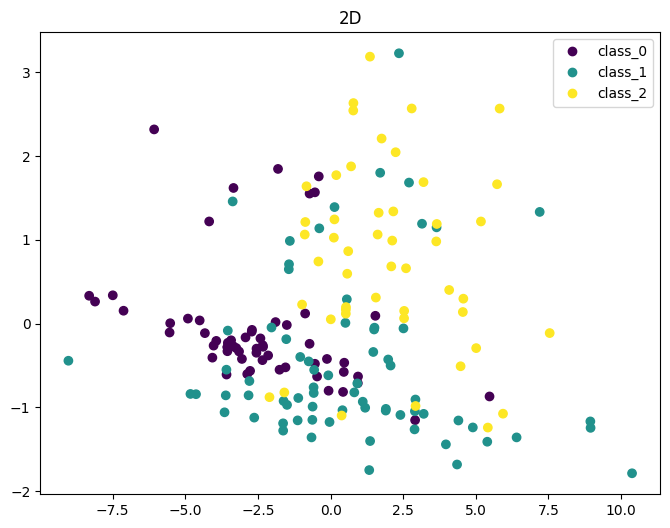

In [8]:
pca = PCA()
plt.figure(figsize=(8,6))
Xt = pca.fit_transform(df)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.title("2D")
plt.show()

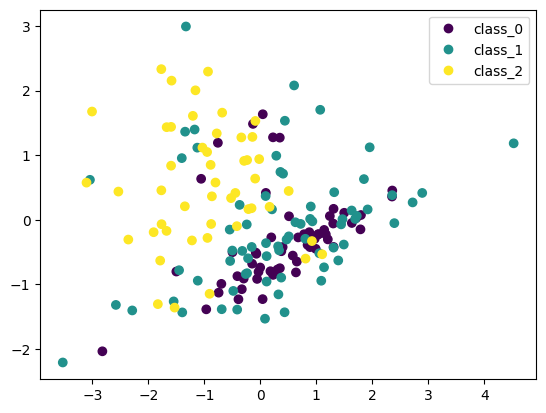

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

In [10]:
#odpowiedz

# Autoenkoder

![image](./imgs/autoenkoder.png "Przykładowa wizualizacja autoenkodera")

Autoenkoder jest nieliniowym uogólnieniem PCA [2]. Budujemy niskowymiarową reprezentację w oparciu o chęć odbudowania tej reprezentacji do oryginału z możliwie małym błędem. 
Architekturę autoenkodera możemy podzielić na dwie części:
1. enkoder $E : X \rightarrow Z $
2. dekoder $ D : Z \rightarrow X $

Części te nie muszą byc jednak symetryczne tak jak na obrazku powyżej.

Na nasze potrzeby załóżmy, że $X$ i $Z$ to przestrzenie wektorowe $\mathbb{R}^m$ i $\mathbb{R}^n$ gdzie $m > n$.

Niech funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$

Optymalizując na reprezentację daną przez parametry autoenkodera, chcemy żeby dla próbki $x$:
$$
y = \mathcal{E} x \\
\hat{x} = \mathcal{D} y
$$
 Różnica między $x$ i $\hat{x}$ była jak najmniejsza.


Poniżej znajdziemy implementację prostego autoenkodera. Tak zaimplementowany autoenkoder poddaliśmy procesowi uczenia na datasecie MNIST. Do wizualizacji postępów rysujemy zredukowaną przez PCA przestrzeń reprezentacji oraz jakość enkodowania dla wybranych przykładów.

In [11]:
import torch
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        encoder_list= [
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, kernel_size=3, stride=2),
            torch.nn.ReLU()
        ]
        self.encoder = torch.nn.Sequential(*encoder_list)    
        decoder_list = [
            torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2),
            torch.nn.Sigmoid()
        ]
        self.decoder = torch.nn.Sequential(*decoder_list)
        
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

In [12]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

torch.manual_seed(1337) 
batch_size = 128
# transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
transforms = Compose([ToTensor()])
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

test_data = MNIST(root='./data/', 
                   train=False, 
                   transform=transforms,    
                   download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

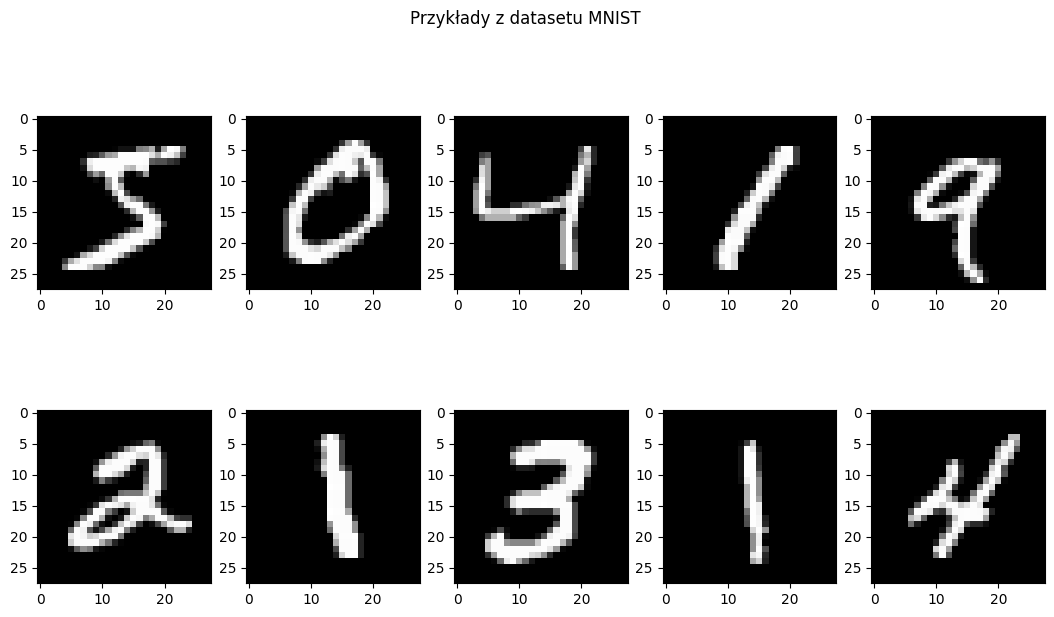

In [13]:
_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
plt.suptitle("Przykłady z datasetu MNIST")
plt.show()

Epoch: 0  |  train loss: 0.0560


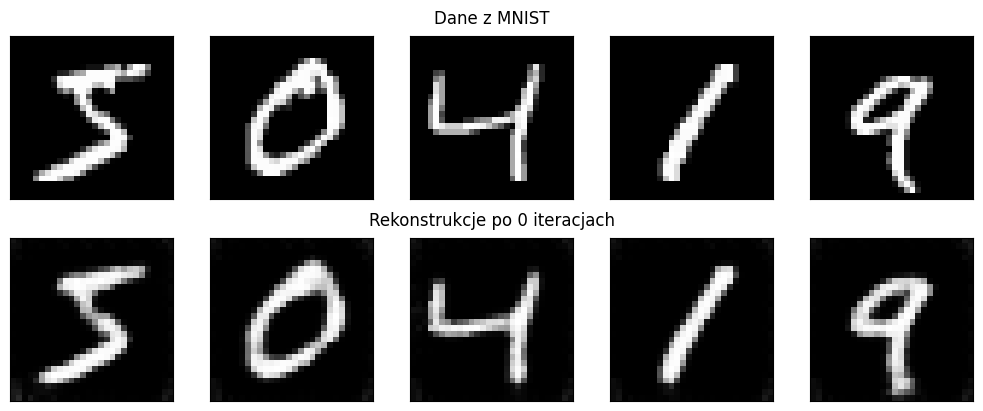

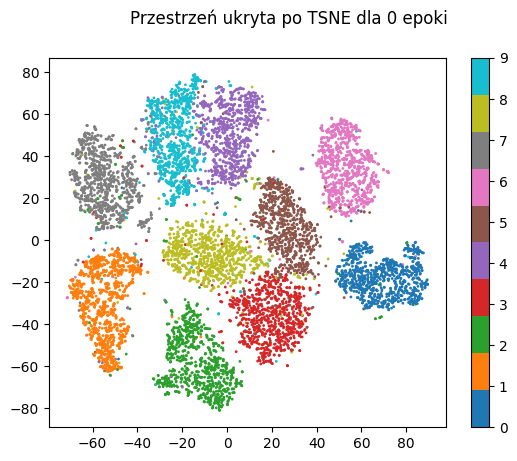

Epoch: 1  |  train loss: 0.0048
Epoch: 2  |  train loss: 0.0035
Epoch: 3  |  train loss: 0.0030
Epoch: 4  |  train loss: 0.0028
Epoch: 5  |  train loss: 0.0026


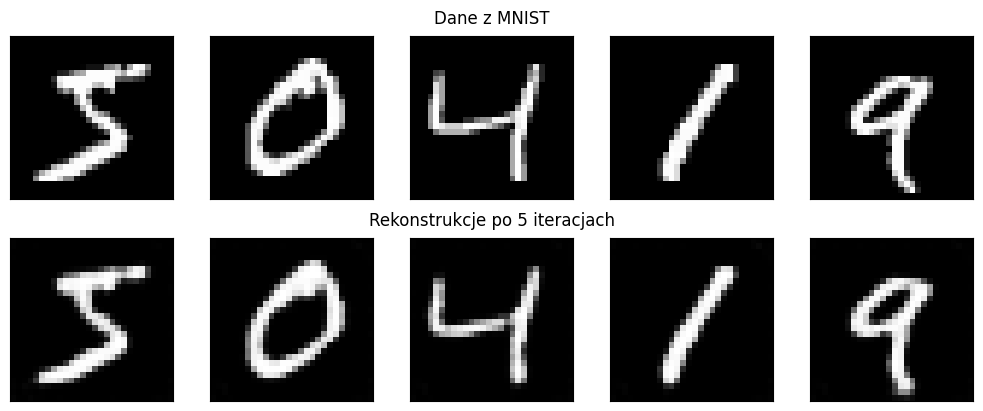

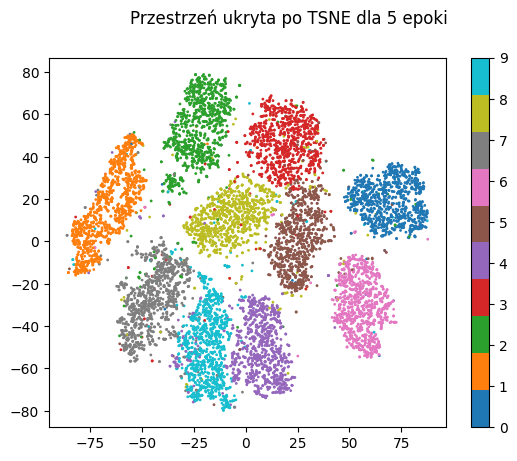

Epoch: 6  |  train loss: 0.0024
Epoch: 7  |  train loss: 0.0022
Epoch: 8  |  train loss: 0.0020
Epoch: 9  |  train loss: 0.0018
Epoch: 10  |  train loss: 0.0017


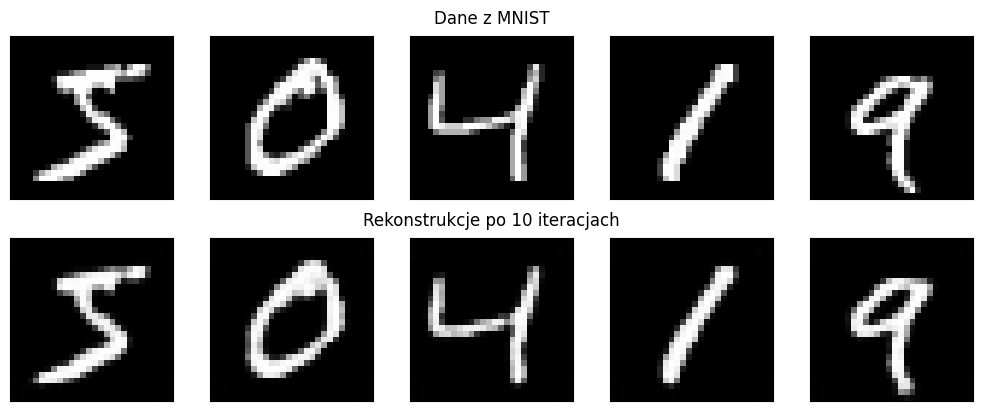

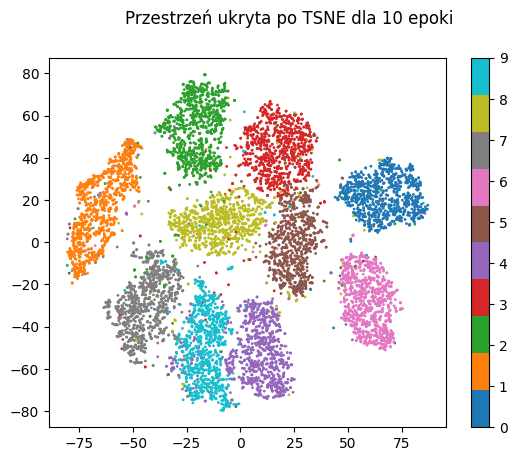

Epoch: 11  |  train loss: 0.0015
Epoch: 12  |  train loss: 0.0014
Epoch: 13  |  train loss: 0.0014
Epoch: 14  |  train loss: 0.0013
Epoch: 15  |  train loss: 0.0013


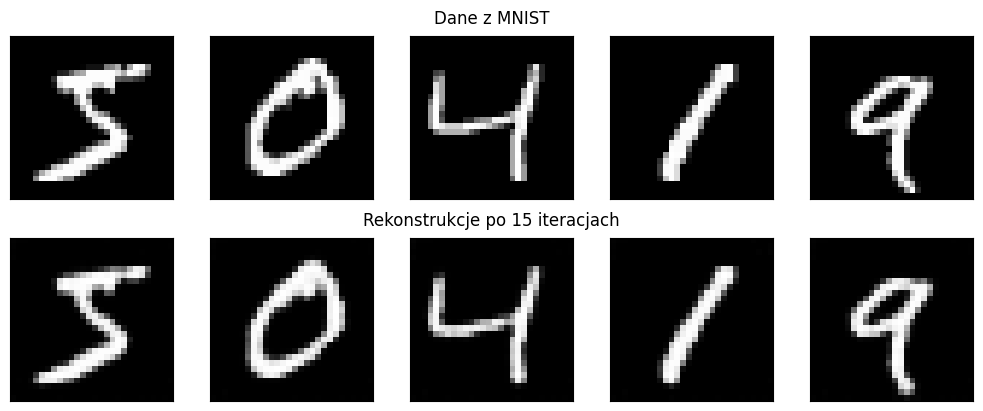

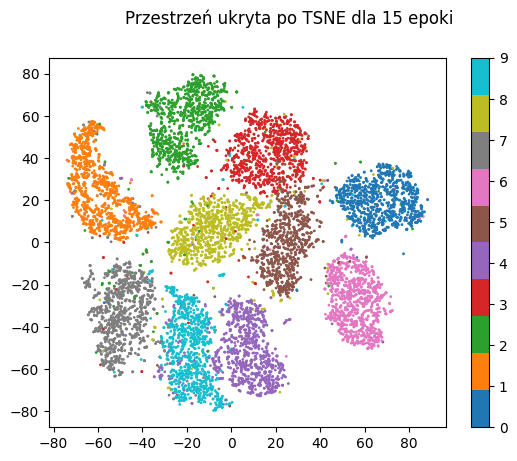

Epoch: 16  |  train loss: 0.0013
Epoch: 17  |  train loss: 0.0013
Epoch: 18  |  train loss: 0.0012
Epoch: 19  |  train loss: 0.0012
Epoch: 20  |  train loss: 0.0012


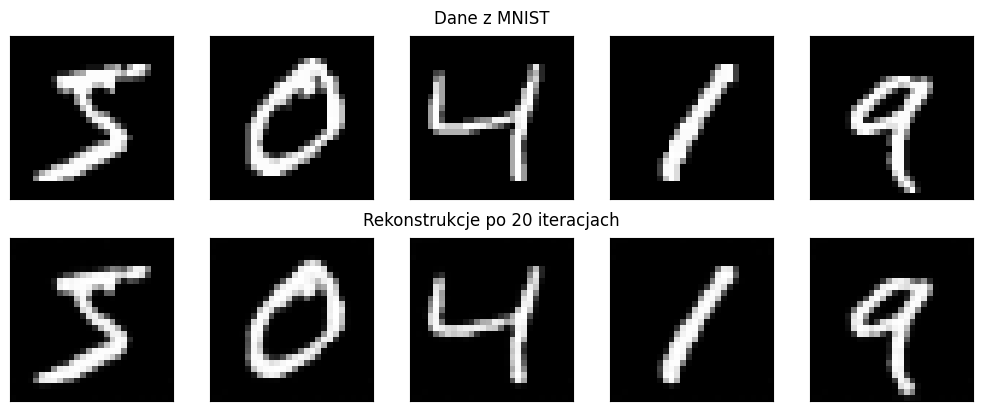

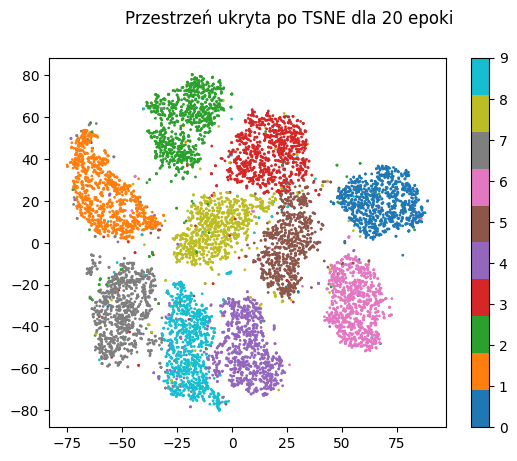

In [17]:
from utils import plot_tsne, plot_dataset

# Hyper Parameters
epochs = 21
LR = 1e-3         # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=64).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        encoded, decoded = autoencoder(x) 
        loss = rec_loss_fn(decoded, x) # calculate loss
        optimizer.zero_grad()        # clear gradients for this training step
        loss.backward()          # backpropagation, compute gradients
        optimizer.step()             # apply gradients
        
        epoch_losses.append(loss.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 5 == 0:
        with torch.no_grad():
            view_data = train_data.data[:5].view(-1, 1, 28, 28) / 255.
            _, decoded_data = autoencoder.forward(train_data.data[:5].view(-1, 1, 28, 28).float().to(device) / 255.)
            decoded_data = decoded_data.cpu().detach().numpy()
            plot_dataset(view_data, epoch, decoded_data)
            x_test_compressed = autoencoder.encoder(test_data.data.view(-1, 1, 28, 28).float().to(device) / 255.)
            plot_tsne(x_test_compressed, test_data.targets, epoch)
            
            

Źródła:
[2] Głębokie uczenie. Wprowadzenie. Jacek Tabor, Marek Śmieja, Łukasz Struski, Przemysław Spurek, Maciej Wołczyk. Wydanie 1. Rozdział 11 Głębokie modele nienadzorowane. (https://helion.pl/ksiazki/glebokie-uczenie-wprowadzenie-jacek-tabor-marek-smieja-lukasz-struski-przemys,glucze.htm#format/d)